Trénujeme NVDA ze sektoru Technology
Epoch 1/50 - Loss: 0.0369
Epoch 2/50 - Loss: 0.0025
Epoch 3/50 - Loss: 0.0020
Epoch 4/50 - Loss: 0.0014
Epoch 5/50 - Loss: 0.0013
Epoch 6/50 - Loss: 0.0014
Epoch 7/50 - Loss: 0.0013
Epoch 8/50 - Loss: 0.0010
Epoch 9/50 - Loss: 0.0010
Epoch 10/50 - Loss: 0.0010
Epoch 11/50 - Loss: 0.0009
Epoch 12/50 - Loss: 0.0009
Epoch 13/50 - Loss: 0.0009
Epoch 14/50 - Loss: 0.0010
Epoch 15/50 - Loss: 0.0007
Epoch 16/50 - Loss: 0.0008
Epoch 17/50 - Loss: 0.0009
Epoch 18/50 - Loss: 0.0008
Epoch 19/50 - Loss: 0.0007
Epoch 20/50 - Loss: 0.0007
Epoch 21/50 - Loss: 0.0007
Epoch 22/50 - Loss: 0.0006
Epoch 23/50 - Loss: 0.0007
Epoch 24/50 - Loss: 0.0006
Epoch 25/50 - Loss: 0.0008
Epoch 26/50 - Loss: 0.0007
Epoch 27/50 - Loss: 0.0007
Epoch 28/50 - Loss: 0.0007
Epoch 29/50 - Loss: 0.0007
Epoch 30/50 - Loss: 0.0006
Epoch 31/50 - Loss: 0.0006
Epoch 32/50 - Loss: 0.0006
Epoch 33/50 - Loss: 0.0007
Epoch 34/50 - Loss: 0.0006
Epoch 35/50 - Loss: 0.0007
Epoch 36/50 - Loss: 0.0007


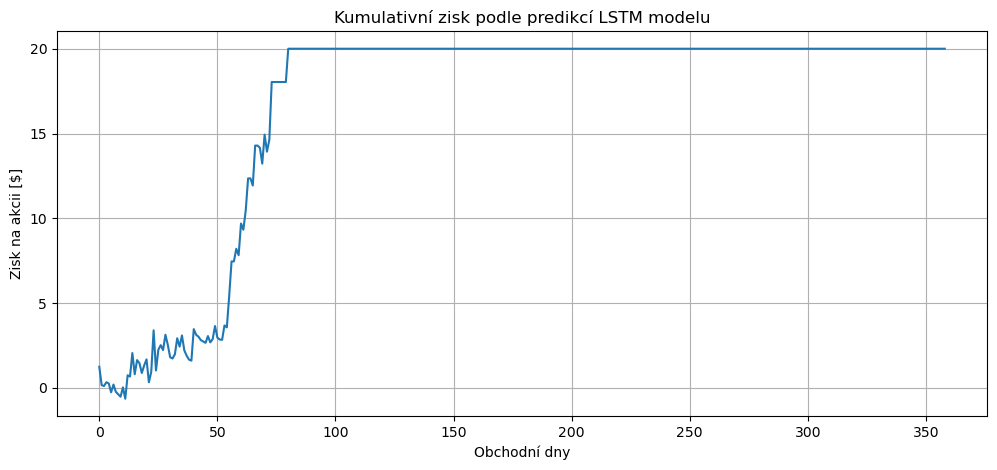

Celkový zisk: 20.01 USD
Průměrný zisk na obchod: 0.0557 USD
Ukázka predikcí vs. skutečnost:
Predikováno: 50.0421, Skutečná: 46.8453
Predikováno: 49.7347, Skutečná: 48.0877
Predikováno: 50.2859, Skutečná: 47.0013
Predikováno: 49.8920, Skutečná: 46.9544
Predikováno: 49.6748, Skutečná: 47.1781


In [23]:
# Tento notebook trénuje LSTM model na jedné vybrané akcii a vizualizuje výsledek predikce a ziskové strategie.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

# Cesta ke složce se skripty (../scripts)
sys.path.append(os.path.abspath("../scripts"))

# Import z vlastních souborů (bez "scripts.")
from utils import TimeSeriesDataset
from lstm_model import get_model
from prepare_data import load_datasets

# Parametry
DEVICE = "cpu"
EPOCHS = 50
LR = 0.01
BATCH_SIZE = 32

# Vyber jednu firmu pro trénink
datasets = load_datasets()
sample_data = datasets[0]

print(f"Trénujeme {sample_data['ticker']} ze sektoru {sample_data['sector']}")

x_train = sample_data["x_train"]
y_train = sample_data["y_train"]
x_val = sample_data["x_val"]
y_val = sample_data["y_val"]
normalizer = sample_data["normalizer"]

# Datasety a DataLoadery
train_ds = TimeSeriesDataset(x_train, y_train)
val_ds = TimeSeriesDataset(x_val, y_val)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# LSTM model
model = get_model().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Tréninková smyčka
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_dl):.4f}")

# Predikce na validační sadě
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(DEVICE)
        preds = model(xb).cpu().numpy()
        all_preds.extend(preds)

# Inverzní transformace
predicted_prices = normalizer.inverse_transform(np.array(all_preds))
actual_prices = normalizer.inverse_transform(y_val)

# Simulovaná strategie (koupím pokud model predikuje růst)
profits = []
for today, predicted, tomorrow in zip(actual_prices[:-1], predicted_prices[:-1], actual_prices[1:]):
    if predicted > today:
        profits.append(tomorrow - today)  # koupíme
    else:
        profits.append(0)  # nekoupíme

cumulative_profit = np.cumsum(profits)

# Graf zisku
plt.figure(figsize=(12, 5))
plt.plot(cumulative_profit)
plt.title("Kumulativní zisk podle predikcí LSTM modelu")
plt.xlabel("Obchodní dny")
plt.ylabel("Zisk na akcii [$]")
plt.grid(True)
plt.show()

# Shrnutí
print(f"Celkový zisk: {cumulative_profit[-1]:.2f} USD")
print(f"Průměrný zisk na obchod: {np.mean(profits):.4f} USD")

print("Ukázka predikcí vs. skutečnost:")
for pred, true in zip(predicted_prices[:5], actual_prices[:5]):
    print(f"Predikováno: {pred:.4f}, Skutečná: {true:.4f}")